In [1]:
import warnings
warnings.filterwarnings('ignore')

import math
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

In [2]:
#read houseprice dataset

df = pd.read_csv('A2_Data/House_Price.csv', index_col='Id') #identify id so not interpreted as feature

In [3]:
# (a) Describe the summary statistics about the data including number of instances, number of features, how many 
# categorical and numerical features, respectively.

n_instances = df.shape[0] #num of instances in dataset
n_features = df.shape[1] #num of features in dataset

numerical = df.select_dtypes(include='number') #identify numerical features
categorical = df.select_dtypes(include='object') #identify categorical features

rcategorical = ['MSSubClass', 'OverallQual', 'OverallCond'] #features to remove from numerical -> categorical
numerical = numerical.drop(columns=rcategorical) #remove features from numerical
categorical = pd.concat([categorical, df[rcategorical]], axis=1) #add features to categorical

numerical_cnt = numerical.shape[1] #num of numerical features
categorical_cnt = categorical.shape[1] #num of categorical features

print("Num -> Instances: ", n_instances)
print("Num -> Features: ", n_features)
print("Num -> Categorical: ", categorical_cnt)
print("Num -> Numerical: ", numerical_cnt)

Num -> Instances:  1460
Num -> Features:  80
Num -> Categorical:  46
Num -> Numerical:  34


In [4]:
# (b) Find the top 5 numerical features highly correlated with the target variable (“SalePrice”) according to the 
# pearson correlation, report the correlation values.

corr = numerical.corr() #numerical correlation matrix
corr = corr['SalePrice'] #identify correlation with SalePrice
corr = corr.sort_values(ascending=False) #sort correlation values
print(df.nlargest(5, 'SalePrice')['SalePrice']) #print top 5 SalePrice values
t_features = [] #array -> store top numerical features
for i in range(1, 6):
    f = corr.index[i] #feature name
    c_v = corr[i] #correlation value
    print("Feature:", f, ", Correlation Value: ", c_v) #print -> feature, correlation value
    t_features.append(f) #append feature -> array

Feature: GrLivArea , Correlation Value:  0.7086244776126515
Feature: GarageCars , Correlation Value:  0.6404091972583519
Feature: GarageArea , Correlation Value:  0.6234314389183622
Feature: TotalBsmtSF , Correlation Value:  0.6135805515591943
Feature: 1stFlrSF , Correlation Value:  0.6058521846919153


Top 5 Features Skewness and Kurtosis
Feature:  GrLivArea , Skewness:  1.365155954773434 , Kurtosis:  4.874265760253215
Feature:  GarageCars , Skewness:  -0.34219689543081294 , Kurtosis:  0.2161348715110729
Feature:  GarageArea , Skewness:  0.1797959420587727 , Kurtosis:  0.9098227950882034
Feature:  TotalBsmtSF , Skewness:  1.522688086978629 , Kurtosis:  13.201041630635025
Feature:  1stFlrSF , Skewness:  1.3753417421837937 , Kurtosis:  5.722076026587489
Feature: SalesPrice, Skewness:  1.880940746034036 , Kurtosis:  6.509812011089439


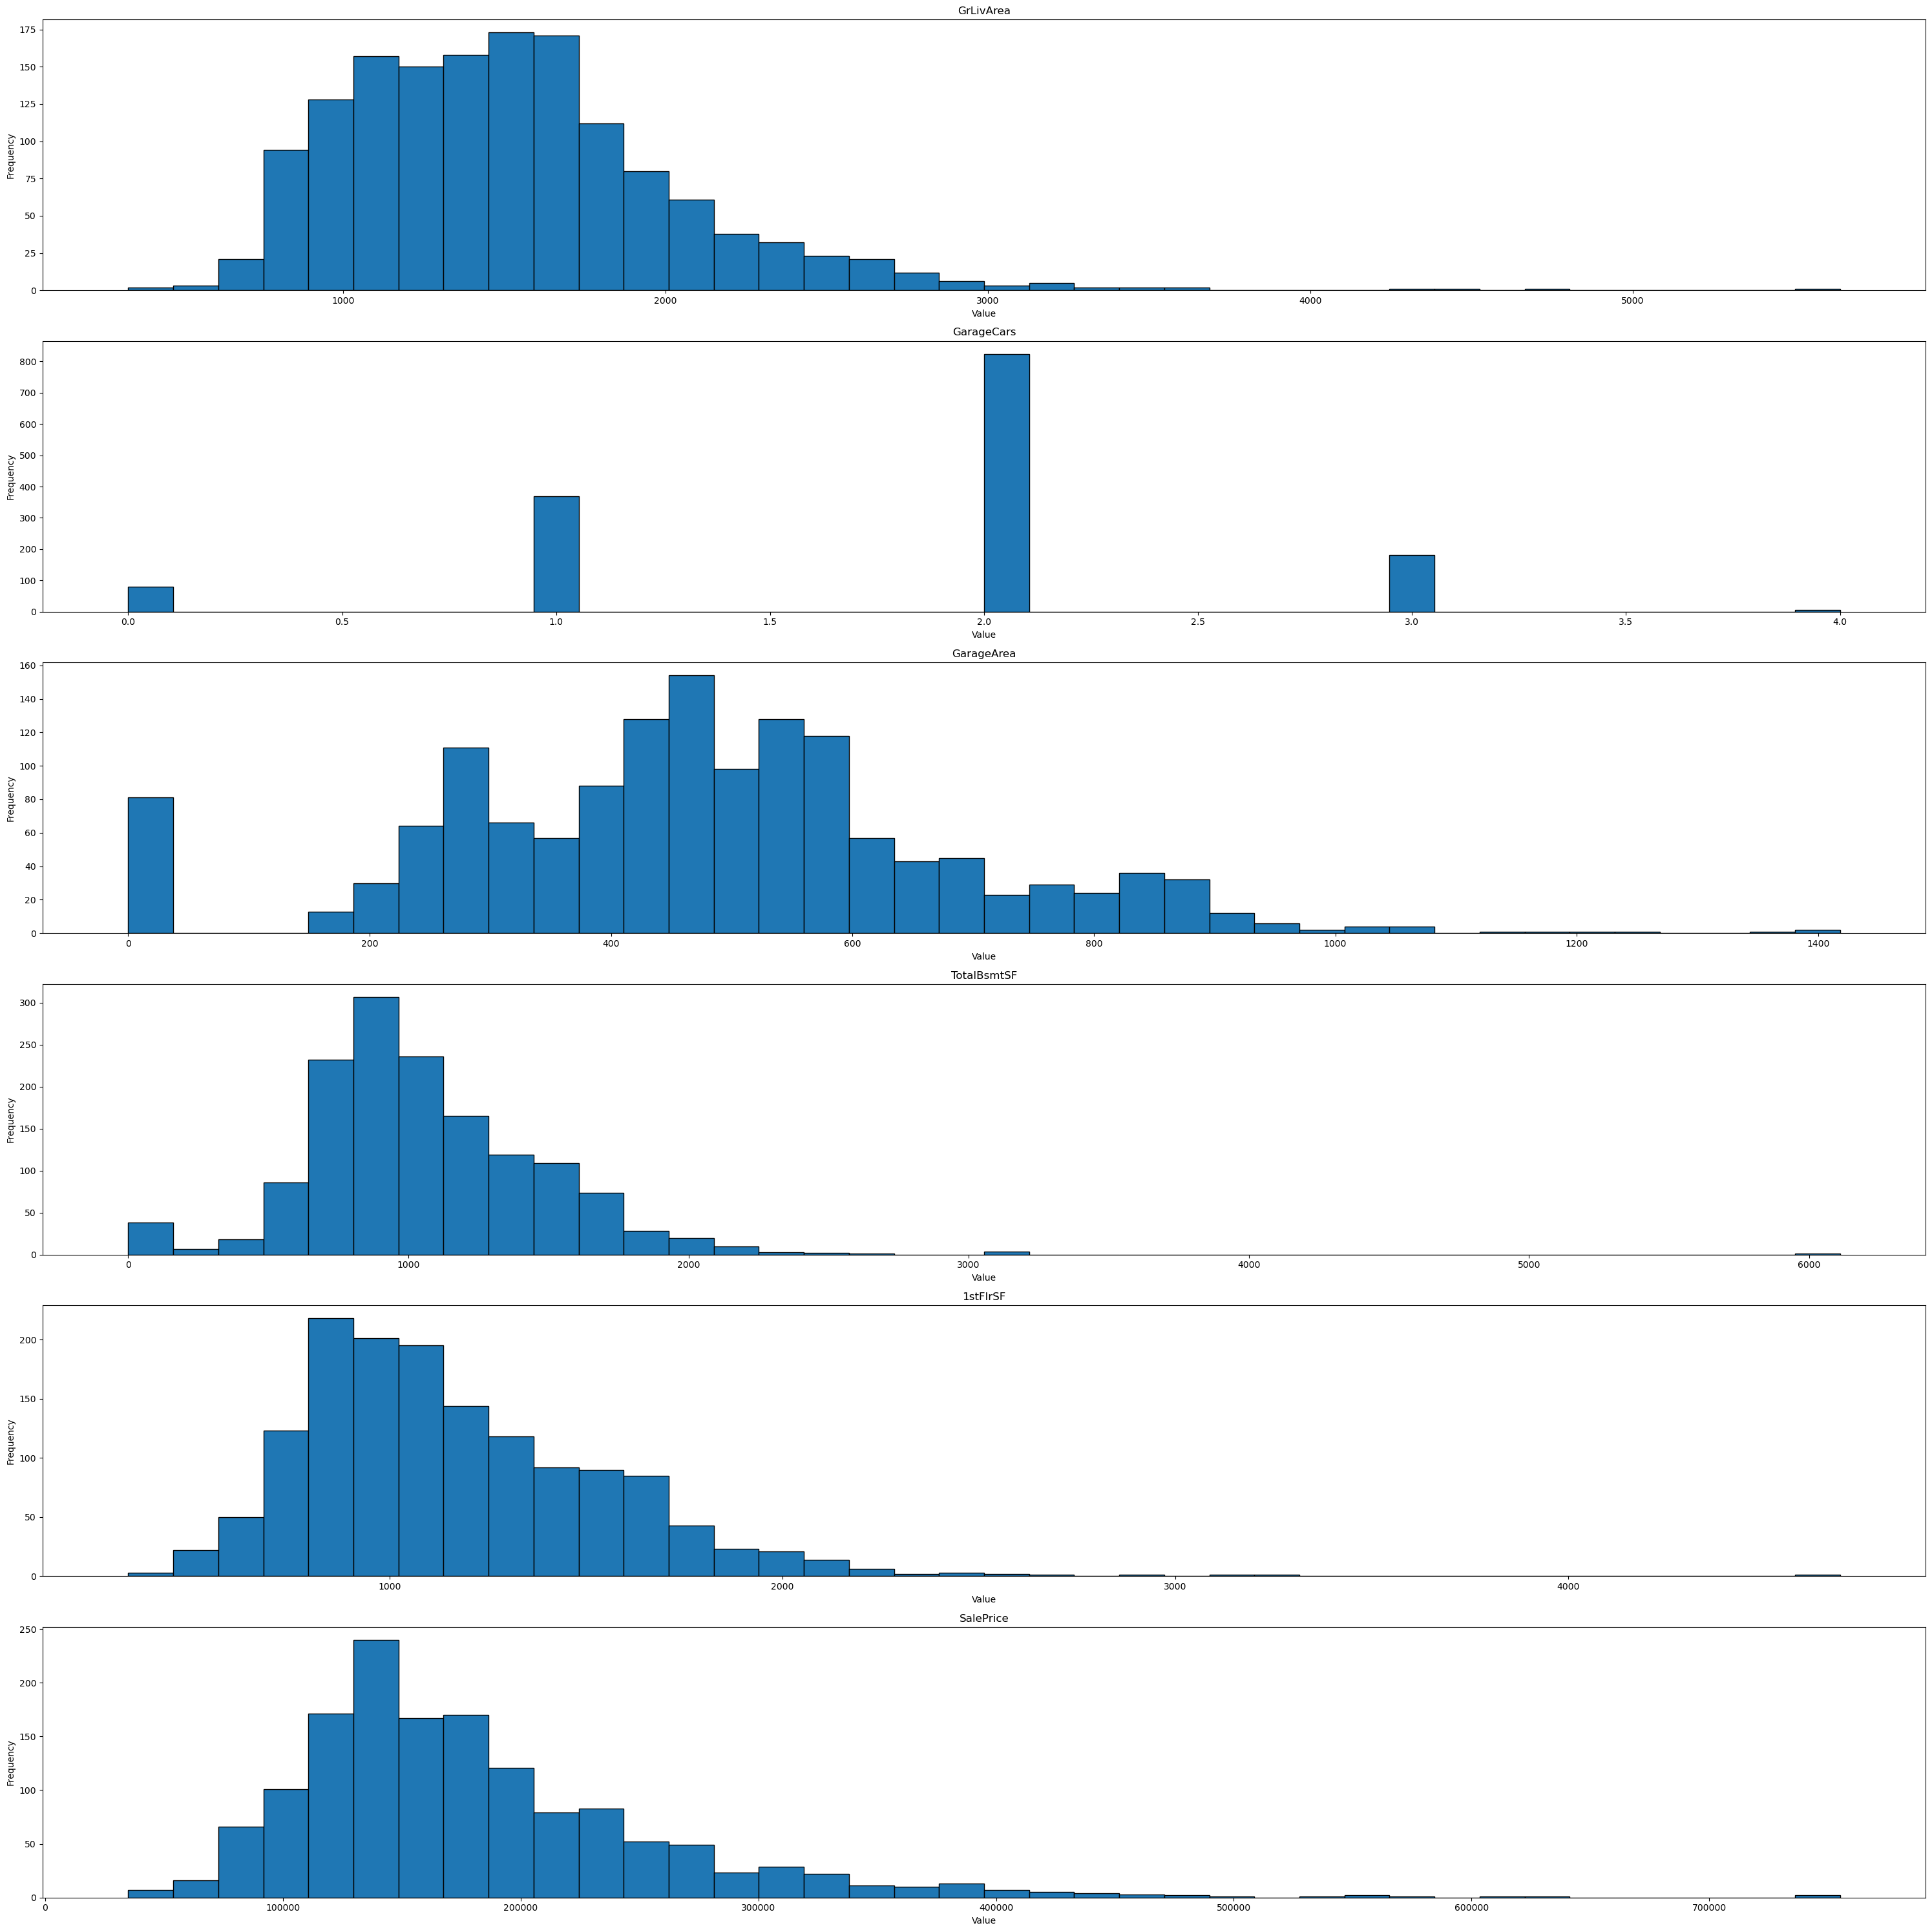

In [5]:
# (c) Plot the distributions of these 5 numerical features found in the previous question and the target variable 
# using histograms, one for each feature/variable, describe how to determine the number of bins, the shape of 
# their distributions with skewness and kurtosis (use Scipy for obtaining skewness and kurtosis values), and 
# tell two patterns from the histograms accordingly. 

fig, axs = plt.subplots(6, 1, figsize=(30, 30))

print("Top 5 Features Skewness and Kurtosis")
for i, feat in enumerate(t_features): #iterate -> top numerical features
    ax = axs[i]
    ax.hist(numerical[feat], bins=int(math.sqrt(n_instances)), edgecolor='black') #plot histogram -> numerical features
    skew = stats.skew(numerical[feat]) #feature skewness
    kurtosis = stats.kurtosis(numerical[feat]) #feature kurtosis
    ax.set_title(feat)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    print("Feature: ", feat, ", Skewness: ", skew, ", Kurtosis: ", kurtosis)

ax = axs[-1]
ax.hist(numerical['SalePrice'], bins=int(math.sqrt(n_instances)), edgecolor='black') #plot histogram -> SalePrice
skew = stats.skew(numerical['SalePrice']) #SalePrice skewness
kurtosis = stats.kurtosis(numerical['SalePrice']) #SalePrice kurtosis
ax.set_title("SalePrice")
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
print("Feature: SalesPrice, Skewness: ", skew, ", Kurtosis: ", kurtosis)

plt.tight_layout()
plt.show()

In [6]:
# (d) Check for missing values. Are there any missing values in the data? write a paragraph to briefly summarise 
# the missing information regarding how many features contain missing values and at what percent.

df_length = len(df) #length of dataset
missingValues = (df.isnull().sum()/df_length) * 100 #percentage of missing/null in dataset
missingValues = missingValues.sort_values(ascending=False) #sort missing values
missingValues = missingValues[missingValues > 0] #filter missing values not 0
missingValues = pd.DataFrame(missingValues.values, missingValues.index) #convert to dataframe

print("Features with percentage missing: ")
print(missingValues)
print("Total number of missing features: ", len(missingValues))

Features with percentage missing: 
                      0
PoolQC        99.520548
MiscFeature   96.301370
Alley         93.767123
Fence         80.753425
MasVnrType    59.726027
FireplaceQu   47.260274
LotFrontage   17.739726
GarageYrBlt    5.547945
GarageCond     5.547945
GarageType     5.547945
GarageFinish   5.547945
GarageQual     5.547945
BsmtExposure   2.602740
BsmtFinType2   2.602740
BsmtCond       2.534247
BsmtQual       2.534247
BsmtFinType1   2.534247
MasVnrArea     0.547945
Electrical     0.068493
Total number of missing features:  19


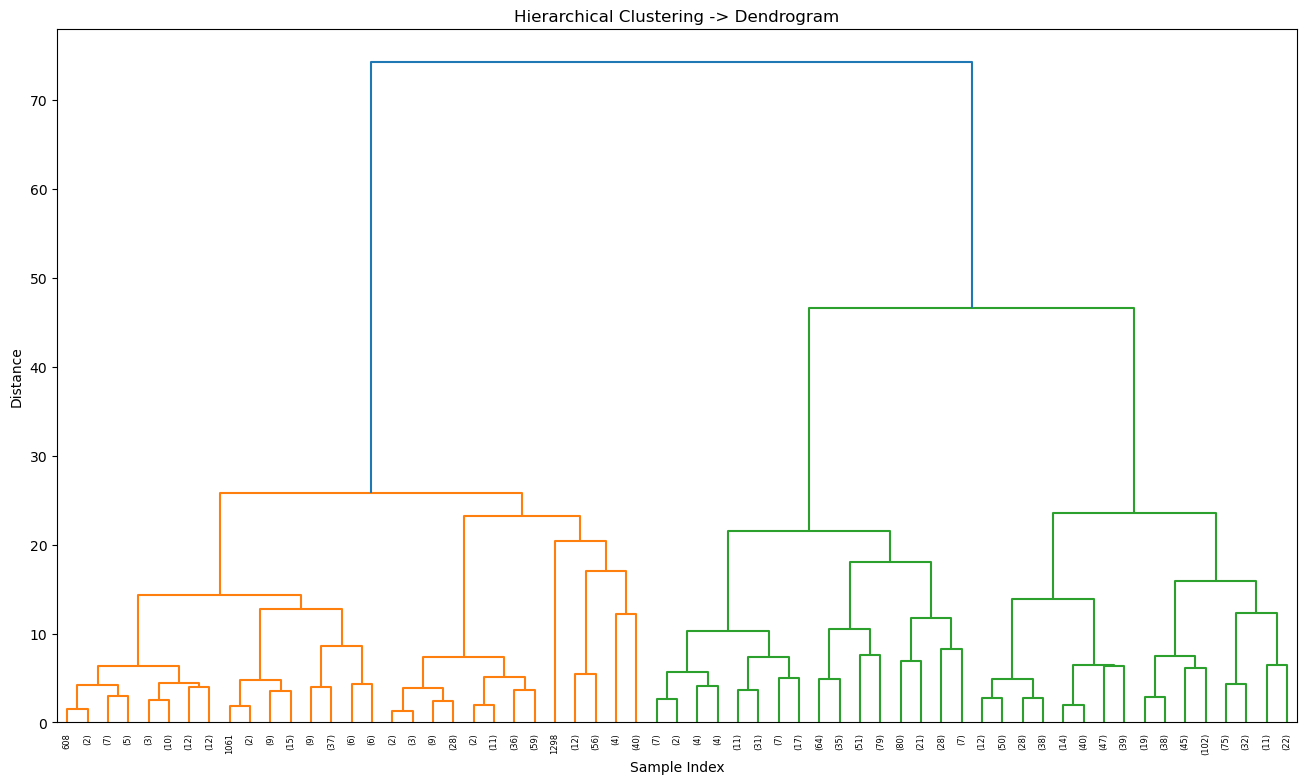

In [7]:
# # 3. (15 marks) EDA using clustering is very useful for understanding the important characteristics of the data. Provide 
# # a further EDA on the dataset using Hierarchical clustering on the 5 numerical features found in 1(b) to answer 
# # the question — “Does the house prices vary by neighbourhood?”. Report the output dendrogram and any other 
# # plots and show how do they help you to answer the question.

# agglomerative clustering, dendrogram

scaler = StandardScaler() #initialize scaler
df[t_features] = scaler.fit_transform(df[t_features]) #scale top numerical features
clustData = df[t_features]

agg = AgglomerativeClustering(distance_threshold=0, n_clusters=None) #initialize agglomerative clustering
clusters = agg.fit_predict(clustData) #fit -> top features

df['Cluster'] = clusters #add cluster to dataset
linkage = linkage(clustData, method='ward') #linkage -> top features

plt.figure(figsize=(16, 9))
dendrogram(linkage, truncate_mode='level', p=5) #plot dendrogram
plt.title("Hierarchical Clustering -> Dendrogram")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()

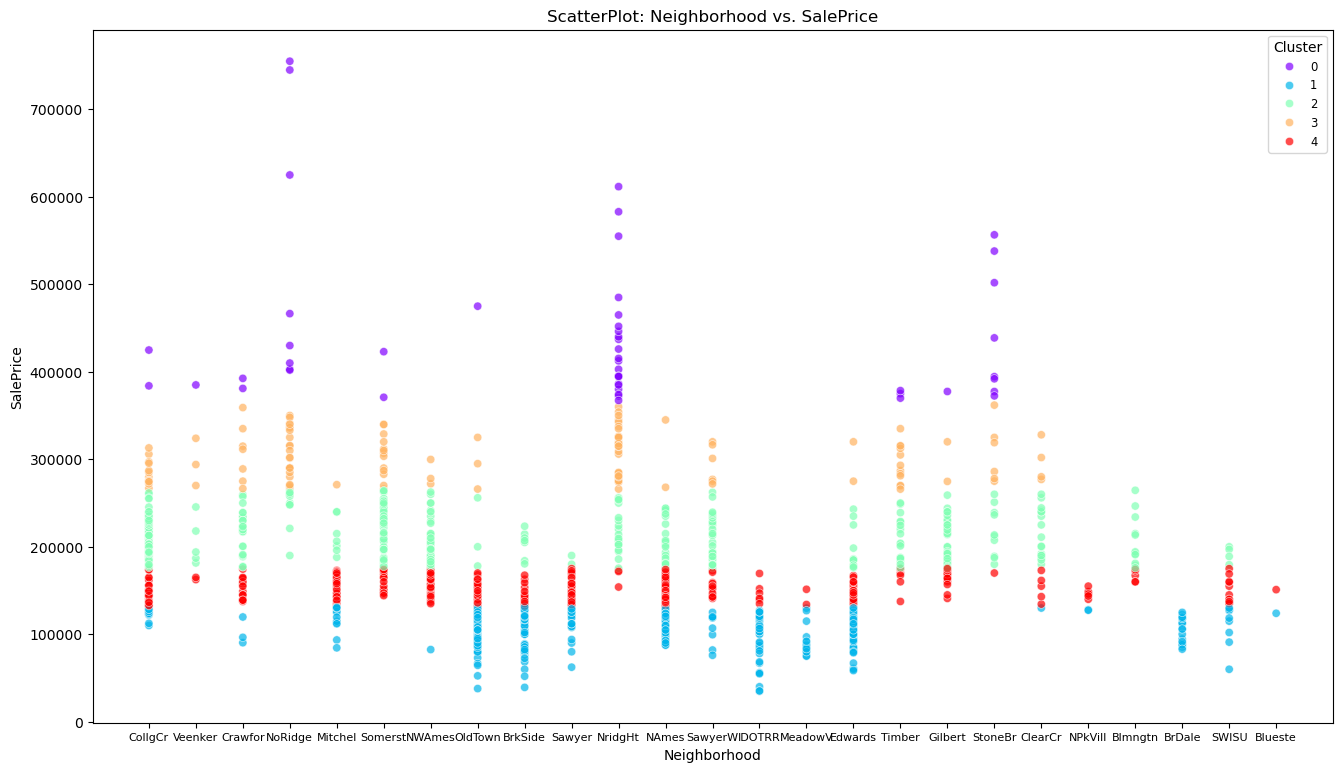

In [8]:
#agglomerative, scatter -> neighborhood vs salesprice

clustData['SalePrice'] = df.loc[clustData.index, 'SalePrice'] #add SalePrice to top features

agg = AgglomerativeClustering(n_clusters=5, linkage='ward') #initialize agglomerative clustering
clusters = agg.fit_predict(clustData) #fit -> top features + salesprice

clustData['Neighborhood'] = df.loc[clustData.index, 'Neighborhood'] #add neighborhood to top features + salesprice

clustData['Cluster'] = clusters #add to cluster

#plot scatter plot -> neighborhood compared to salesprice

plt.figure(figsize=(16, 9))
sns.scatterplot(x='Neighborhood', y='SalePrice', data=clustData, hue='Cluster', palette='rainbow', alpha=0.7)
plt.legend(title='Cluster', fontsize='small')
plt.title("ScatterPlot: Neighborhood vs. SalePrice")
plt.ylabel('SalePrice')
plt.xlabel('Neighborhood')
plt.xticks(size=8)
plt.show()